In [1]:
import pickle
import rpy2.robjects as robjects
import os
import xgboost
import scipy.stats as st
import pandas as pd
import numpy as np
import scipy.stats as ss
import seaborn as sns
sns.set()
from sklearn import decomposition
from sklearn.decomposition import PCA
from sklearn.linear_model import LassoCV
from sklearn.datasets import make_regression
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
title_fontsize = 20
xlabel_fontsize = 18
ylabel_fontsize = 18
legend_fontsize = 14
ticks_fontsize = 18
figure_format = "pdf"
%matplotlib inline

## Load metadata for samples and subjects in GTEx

In [2]:
# load sample metadata: 18220 samples, 73 technnical parameters
sampleMetaData = pd.read_csv('./GTEx_V8_RawData/GTEx_Analysis_2017-06-05_v8_Annotations_SampleAttributesDS.txt', sep = '\t', header = 'infer', index_col=0)
# load sample metadata: 948 people, 174 phenotipic parameters
subjectMetaData = pd.read_csv('./GTEx_V8_RawData/GTEx_Analysis_2017-06-05_v8_Annotations_SubjectPhenotypesDS.txt', sep = '\t', header = 'infer', index_col=0)

c:\python37\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Load data by tissue

In [18]:
def load_data(tissue, datatype, date=None):
    """ Load gene expression for each tissue.
    
     Parameters
    ----------
    tissue: one of GTEx tissues
    datatype: one of the strings "tissue", "subtissue", "deconvolved" depending on the datatype needed
    
     Outputs
    ----------
    data : pd.DataFrame
        genes x samples dataframe
    age : np.array, int
        age of each subject who provided the sample for the tissue
    SMRIN : np.array, float
        RIN number (RNA integrity number) for each sample
    SMTSISCH : np.array, int
        total ischemic time for each sample
    """
    
    if datatype == "tissue":
        #process pkl files (whole tissue)
        data_p_file = "./GTEx_V8_RNASeq_subTissueTypes/Expr_by_tissue/Expr_by_tissue/GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_tpm_"+\
        str(tissue)+".pkl"
        if os.path.exists(data_p_file):
            data = pd.read_pickle(data_p_file)

            gene_ids = data['Name']
            gene_names = data['Description']
            data.index = gene_ids
            data = data.iloc[:,2:]
    
    elif datatype == "subtissue":
        #process r files (subtissues)
        data_r_file = "./GTEx_V8_RNASeq_subTissueTypes/GTEx_" + str(tissue) + ".RData"

        if os.path.exists(data_r_file):

            def load_file(filename):
                robjects.r['load'](filename)
                matrix = robjects.r['GTEx_RNAseq']
                df = pd.DataFrame(
                    np.asarray(matrix.memoryview()),
                    index=matrix.rownames,
                    columns=matrix.colnames,
                    copy=True)
                robjects.globalenv.clear()
                return df

            data = load_file(data_r_file)
    
    elif datatype == "deconvolved":
        
        #process r files (deconvolved: 10KGene Extracted)
        data_r_deconvolved_10K_file = "./data_to_Elvira/" + "10KGene_" + "Extracted_" + str(tissue) + "_cell_type_assignment_" + str(date) + ".RData"

        if os.path.exists(data_r_deconvolved_10K_file):

            def load_file3d(filename):
                robjects.r['load'](filename)
                matrix = robjects.r['CDSeq_estGEP_sample_specific']
                indices = robjects.r('dimnames(CDSeq_estGEP_sample_specific)')
                array = np.asarray(matrix.memoryview()).copy()
                out = []
                for i in range(array.shape[1]):
                    df = pd.DataFrame(
                        array[:,i,:],
                        index=indices[0],
                        columns=indices[2])
                    out.append((indices[1][i],df.T))
                robjects.globalenv.clear()
                return out

            data = load_file3d(data_r_deconvolved_10K_file)
    
        #process r files (deconvolved: Extracted)
        data_r_deconvolved_file = "./data_to_Elvira/" + "Extracted_" + str(tissue) + "_cell_type_assignment_" + str(date) + ".RData"

        if os.path.exists(data_r_deconvolved_file):
            
            def load_file3d(filename):
                robjects.r['load'](filename)
                matrix = robjects.r['CDSeq_estGEP_sample_specific']
                indices = robjects.r('dimnames(CDSeq_estGEP_sample_specific)')
                array = np.asarray(matrix.memoryview()).copy()
                out = []
                for i in range(array.shape[1]):
                    df = pd.DataFrame(
                        array[:,i,:],
                        index=indices[0],
                        columns=indices[2])
                    out.append((indices[1][i],df.T))
                robjects.globalenv.clear()
                return out

            data = load_file3d(data_r_deconvolved_file)
           
    else:
        print("please specify a valid datatype: tissue, subtissue, or deconvolved")
        return
    
    print(data.shape[1], " samples, ", data.shape[0], "genes")
    
    # filter out genes that are expressed in fewer than 10% of samples
    data = data[(data.T == 0).sum()<0.1*data.shape[1]]
    print(str(len((data.T == 0).sum()>0.1*data.shape[1])) + " genes filtered out")
    
    # filter out samples that express fewer than 10% of genes
    data = data.loc[:,data.columns[(pd.isna(data)).sum()<0.1*data.shape[0]]]
    print(str(len(data.columns[(pd.isna(data)).sum()>0.1*data.shape[0]])) + " samples filtered out")
    
    # load age, SNRIN, and SMTSUSCH values for each subject
    subject_ids = [subject_id.split("-")[0]+"-"+subject_id.split("-")[1] for subject_id in \
     data.columns.tolist()]
    age = [np.asarray(subjectMetaData.loc[subjectMetaData.index==subject_id,'AGE'])[0] \
                   for subject_id in subject_ids]
    SMRIN = [np.asarray(sampleMetaData.loc[sampleMetaData.index==sample_id,'SMRIN'])[0] \
                   for sample_id in data.columns.tolist()]
    SMTSISCH = [np.asarray(sampleMetaData.loc[sampleMetaData.index==sample_id,'SMTSISCH'])[0] \
                   for sample_id in data.columns.tolist()]
    return data, age, SMRIN, SMTSISCH

## Load and filter data

Choosing tissues that have > 800 samples (8 tissues in GTEx). It is arbitrary, so you can choose a lower threshold to study more tissues if your age prediciton model works even for fewer samples

In [19]:
tissues = ['Muscle',
 'Blood Vessel',
 'Brain',
 'Blood',
 'Skin',
 'Esophagus',
 'Heart',
 'Adipose Tissue']
# tissues = ['Adipose Tissue', 'Adipose_Subcutaneous'] 
# tissues = ['Muscle', 'Blood Vessel'] # tissues

In [20]:
data = {}
age = {}
SMRIN = {}
SMTSISCH = {}

for tissue in tissues:
    data[tissue], age[tissue], SMRIN[tissue], SMTSISCH[tissue] = load_data(tissue, "tissue")

804  samples,  56200 genes
19544 genes filtered out
0 samples filtered out
1335  samples,  56200 genes
21218 genes filtered out
0 samples filtered out
2642  samples,  56200 genes
22135 genes filtered out
0 samples filtered out
1702  samples,  56200 genes
19334 genes filtered out
0 samples filtered out
1811  samples,  56200 genes
20767 genes filtered out
0 samples filtered out
1451  samples,  56200 genes
21402 genes filtered out
0 samples filtered out
866  samples,  56200 genes
20406 genes filtered out
0 samples filtered out
1204  samples,  56200 genes
22099 genes filtered out
0 samples filtered out


## Correct for covariates and remove outliers

### Find genes with weak correlation with age

In [10]:
def define_non_age_related_genes(data, age):
    rhos = np.zeros((len(data.index.tolist())))
    spear_pvals = np.zeros((len(data.index.tolist())))
    for i, gene in enumerate(data.index.tolist()):
        rhos[i], spear_pvals[i] = ss.spearmanr(data.loc[gene,:], age, nan_policy = 'omit')
    gene_idxs = range(data.shape[0])
    gene_idxs = [gene_idx for gene_idx in gene_idxs if spear_pvals[gene_idx]>0.01]
    print(str(len(gene_idxs)) + " genes with no correlation with age")
    non_aging_expr = data.iloc[gene_idxs,:]
    return(non_aging_expr)

### Perform SVD (singular value decomposition) of non-age related gene expression

In [11]:
def svd(non_aging_expr, n_comp = 50):
    u, s, vh  = np.linalg.svd(non_aging_expr.transpose())
    d2 = s**2
    print("first " + str(n_comp) + " components explain " + str(d2[:n_comp].sum()/d2.sum()) + " variability")
    print(u.shape)
    u_top_10 = u[:n_comp,:]
    x_0 = u_top_10*s
    return(x_0)

### Regress out non-age-related covariates

In [12]:
import sklearn.linear_model as linear_model
def linear_regression(x_train, y_train):
    ols = linear_model.LinearRegression()
    model = ols.fit(x_train, y_train)
    return ols.coef_, ols.intercept_, ols.predict(x_train)

def regress_covariates(data, x_0):
    coeffs, intercepts, prediction = linear_regression(x_0.transpose(), data.transpose()) 
    residual = (data.transpose()-np.asmatrix(x_0.transpose())*coeffs.transpose()).transpose()
    return residual

### Exclude non-age-related genes

In [13]:
def exclude_non_age_related_genes(residual, gene_idxs):
    aging_gene_idxs = [i for i in range(len(residual.index)) if i not in gene_idxs]
    residual_aging = residual.iloc[aging_gene_idxs,:]
    return(residual_aging)

### Remove outliers

In [14]:
def plot_PCA(X, ax, tissue):
    for i in range(len(X[:, 0])):
        ax.scatter(X[i, 0], X[i, 1], color = 'C0')
    ax.set_title(tissue, fontsize = title_fontsize)
    ax.set_xlabel('PC1', fontsize = xlabel_fontsize)
    ax.set_xlabel('PC2', fontsize = ylabel_fontsize)

In [15]:
from sklearn import decomposition
def detect_outliers(residual_aging, tissue):
    pca = decomposition.PCA(n_components=2)
    X = residual_aging.transpose().copy()
    pca.fit(X)
    X = pca.transform(X)
    fig, ax = plt.subplots(1, 1, figsize=(7, 5))
    plot_PCA(X, ax, tissue)
    q1 = pd.DataFrame(X[:, 0]).quantile(0.999)
    q2 = pd.DataFrame(X[:, 1]).quantile(0.999)
    print(q1[0])
    print(q2[0])
    residual_no_outliers = residual_aging.iloc[:,np.asarray([j for j in \
                                                             range(len(residual_aging.columns)) \
                                                             if X[j, 0] < q1[0] and X[j, 1] < q2[0]])]
    print(str(residual_aging.shape[0] - residual_no_outliers.shape[0]) + " outliers removed")
    
    subj_ids = [subject_id.split("-")[0]+"-"+subject_id.split("-")[1] for subject_id in \
                residual_no_outliers.columns.tolist()]
    ages = [np.asarray(subjectMetaData.loc[subjectMetaData.index==subject_id,'AGE'])[0] \
                   for subject_id in subj_ids]
    SMRINs = [np.asarray(sampleMetaData.loc[sampleMetaData.index==sample_id,'SMRIN'])[0] \
                   for sample_id in residual_no_outliers.columns.tolist()]
    SMTSISCHs = [np.asarray(sampleMetaData.loc[sampleMetaData.index==sample_id,'SMTSISCH'])[0] \
                   for sample_id in residual_no_outliers.columns.tolist()]
    return residual_no_outliers, ages, SMRINs, SMTSISCHs

Muscle
9098 genes with no correlation with age
first 50 components explain 0.9998112297541029 variability
(803, 803)
66990.76865243501
76452.38636544714
0 outliers removed
Blood Vessel
8429 genes with no correlation with age
first 50 components explain 0.9984083167856997 variability
(1335, 1335)
103462.3685655455
24082.783320975082
0 outliers removed


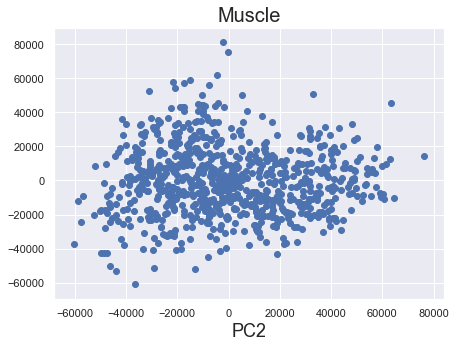

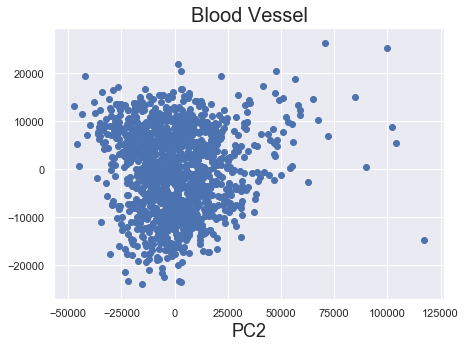

In [16]:
non_aging_expr = {}
x_0 = {}
residual = {}
residual_aging = {}
residual_no_outliers = {}
ages = {}
SMRINs = {}
SMTSISCHs = {}

for i, tissue in enumerate(tissues):
        print(tissue)
        
        non_aging_expr[tissue] = define_non_age_related_genes(data[tissue], age[tissue])
        x_0[tissue] = svd(non_aging_expr[tissue], n_comp=50)
        residual[tissue] = regress_covariates(data[tissue], x_0[tissue])
        residual_aging[tissue] = exclude_non_age_related_genes(residual[tissue], \
                                                               non_aging_expr[tissue].index.tolist())
        residual_no_outliers[tissue], ages[tissue], SMRINs[tissue], SMTSISCHs[tissue] = \
        detect_outliers(residual_aging[tissue], tissue)

## Build the model predicting age with xgboost

In [8]:
def split_train_valid_test(num_examples,training_proportion,validation_proportion,test_proportion):
    assert training_proportion<=1.0
    assert validation_proportion<=1.0
    assert test_proportion<=1.0
    assert (training_proportion+validation_proportion+test_proportion)<=1.0

    idx_shuff=np.random.RandomState(seed=77).permutation(range(num_examples))

    training_threshold=int(num_examples*training_proportion)
    validation_threshold=int(num_examples*(training_proportion+validation_proportion))

    training=range(training_threshold)
    validation=range(training_threshold,min(validation_threshold,num_examples))
    test=range(validation_threshold,num_examples)

    return(idx_shuff[list(training)],idx_shuff[list(validation)],idx_shuff[list(test)])

In [9]:
import scipy.stats as st
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error

def xgboost_model(x_train, y_train, x_test, y_test, n_iter=2, cv=5): # adapted from UROP work, changed n_iter from 10 to 2

    dtrain = xgb.DMatrix(x_train, y_train)
    dtest = xgb.DMatrix(x_test, y_test)
    
#     params = {
#         # Parameters that we are going to tune.
#         'max_depth':6,
#         'min_child_weight': 1,
#         'eta':.3,
#         'subsample': 1,
#         'colsample_bytree': 1,
#         # Other parameters
#         'objective':'reg:squarederror',
#     }
#     params['eval_metric'] = "mae"
#     num_boost_round = 999
    
#     # "Learn" the mean from the training data
#     mean_train = np.mean(y_train)
#     # Get predictions on the test set
#     baseline_predictions = np.ones(y_test.shape) * mean_train
#     # Compute MAE
#     mae_baseline = mean_absolute_error(y_test, baseline_predictions)
#     print("Baseline MAE is {:.2f}".format(mae_baseline)) # baseline is 9.81

#     model = xgb.train(
#         params,
#         dtrain,
#         num_boost_round=num_boost_round,
#         evals=[(dtest, "Test")],
#         early_stopping_rounds=10
#     )
#     print("Best MAE: {:.2f} with {} rounds".format(
#                  model.best_score,
#                  model.best_iteration+1))
# #     Best MAE: 8.10 with 17 rounds

#     cv_results = xgb.cv(
#         params,
#         dtrain,
#         num_boost_round=num_boost_round,
#         seed=42,
#         nfold=5,
#         metrics={'mae'},
#         early_stopping_rounds=10
#     )
#     print(cv_results)
#         train-mae-mean  train-mae-std  test-mae-mean  test-mae-std
#     32        0.021495       0.002374       8.656529      0.594512

    n_estimators = [100, 150, 200, 250, 300] 
    max_depth = [6, 8, 10, 12]
    min_child_weight = [1, 2, 4, 8] 
    learning_rate = [.3, .1, .03, .01, .003, .001]
    subsample = [.8, .9, 1.0]
    colsample = [.8, .9, 1.0]

#     from_zero_positive = [0, 0.5, 1] #st.expon(0, 10) #same, for reg_alpha
#     reg_lambda = st.expon(0, 10) #same
#     scale_pos_weight = [1,2,3,4,5,6,7,8,9,10] #scale_pos_weight (1:1 ratio) as we match class imbalance #[1,2,3,4,5,6,7,8,9,10]
    
    random_grid = {'n_estimators': n_estimators,
                    'max_depth': max_depth,
                    'learning_rate':learning_rate,
                    "min_child_weight": min_child_weight,
                    "colsample_bytree": colsample,
                    "subsample": subsample}
    xgb_tune = xgb.XGBRegressor()
#     xgb_tune = xgb.XGBRegressor(tree_method='gpu_hist') # gpu enabled

#     param = {'n_estimators': 20}
# #     num_round = 2
#     clf = xgb.XGBRegressor(missing=np.nan)
#     clf.set_params(**param)
#     clf.fit(x_train, y_train)
#     print("model trained")
    
#     preds = clf.predict(x_test)
#     return preds

#     bst = xgb.train(param, x_train, num_round)
#     # make prediction
# #     preds = bst.predict(dtest)
#     return bst

    print("done prior to search")
    xgb_hyper = RandomizedSearchCV(xgb_tune,random_grid, n_iter = n_iter, cv = cv, random_state=42, n_jobs = -1,scoring='neg_root_mean_squared_error', return_train_score = True)
    xgb_hyper.fit(x_train, y_train)
    print("done after search")
    preds = xgb_hyper.predict(x_test)
    
    parameter_tuning = xgb_hyper.cv_results_
    parameter_tuning = pd.DataFrame(parameter_tuning)
    print(parameter_tuning)
    print(parameter_tuning[['params', 'rank_test_score', 'mean_test_score', 'std_test_score']])
    print(xgb_hyper.best_params_)
    print(xgb_hyper.best_score_)
#     return xgb_hyper.best_estimator_,parameter_tuning 
    return preds

In [45]:
def fit_xgboost_model(residual_no_outliers, ages, n_iter=5):
    """ Build an age predictor with the xgboost model and estimate its performance.
    
     Parameters
    ----------
    residual_no_outliers: pd.DataFrame
        gene expression for a tissue after all preprocessing: \
        - QC of genes and samples
        - regression of technical and phenotipic covariates explaining most of the variability \
            (except age, we need this variability, so we don't regress it out)
        - removal of outliers
    ages : np.array, int
        ages of samples in a tissue gene expression matrix
        
     Outputs
    ----------
    genes : np.array, str
        genes that are predictive of the age according to the lasso model
    score : float
        coefficient of determination R^2 of the prediction
    pearsonr : float
        Pearson's correlation coefficient
    ages_test : np.array, int
        true ages for the test set
    ages_pred_test : np.array, int
        predicted ages for the test set
    """
    ages_all = ages
    
    # built the age prediction model with the lasso algorithm with cross-validation
    X = residual_no_outliers.transpose()
    y = ages_all
    
    # split dataset into training, validation, and test sets
    train, test, val = split_train_valid_test(residual_no_outliers.shape[1], 0.7, 0.3, 0)
    ages_train = np.asarray([ages[i] for i in train])
    ages_test = np.asarray([ages[i] for i in test])
    
    # calculate age predicted by the model and 
    # correlation of the predicted age with chronological age
    
    x_train = residual_no_outliers.iloc[:,train].transpose()
    x_test = residual_no_outliers.iloc[:,test].transpose()
    print("data done")
    print(x_train.shape, x_test.shape, ages_train.shape, ages_test.shape)
#     ages_pred_test = xgboost_model(x_train, ages_train, x_test, ages_test, n_iter=n_iter)
    ages_pred_test = final_xgboost_model(x_train, ages_train, x_test, ages_test) # replaced with hardcoded values

    print("predictions made")

    pearsonr = ss.pearsonr(ages_pred_test, ages_test)
    print(pearsonr)
    
    # plot clock prediction
    fig, ax = plt.subplots(1, 1, figsize=(7, 5))
    ax.scatter(ages_test, ages_pred_test)
    ax.set_xlabel("Chronological age, years", fontsize = xlabel_fontsize)
    ax.set_ylabel("Predicted age, years", fontsize = ylabel_fontsize)
    ax.set_title(str(tissue),  fontsize = title_fontsize)
    textstr = "Pearson's r=" + str(round(pearsonr[0],2))
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)
    plt.tight_layout()
    pp = "/om2/user/elvira/figures/Aging_clock/Clock_" + str(tissue) + figure_format
#     plt.savefig(pp, format = figure_format)
#     return(genes, score, pearsonr, ages_test, ages_pred_test)
    return(pearsonr, ages_test, ages_pred_test)

pearson_corr = {}
prediction = {}
true = {}

In [60]:
def final_xgboost_model(x_train, y_train, x_test, y_test): # using set hyperparameters
    
    dtrain = xgb.DMatrix(x_train, y_train)
    dtest = xgb.DMatrix(x_test, y_test)
        
#     # refactor later, no need for RandomizedSearchCV
#     n_estimators = [150] 
#     max_depth = [6]
#     min_child_weight = [1] 
#     learning_rate = [.1]
#     subsample = [1.0]
#     colsample = [.9]

#     random_grid = {'n_estimators': n_estimators,
#                     'max_depth': max_depth,
#                     'learning_rate':learning_rate,
#                     "min_child_weight": min_child_weight,
#                     "colsample_bytree": colsample,
#                     "subsample": subsample}
#     xgb_tune = xgb.XGBRegressor()
    
    param = {'n_estimators': 150,
            'max_depth': 6,
            'learning_rate': 0.1,
            'min_child_weight': 1,
            'colsample_bytree': .9,
            'subsample': 1.0}
    clf = xgb.XGBRegressor()
    clf.set_params(**param)
    clf.fit(x_train, y_train)
    
    preds = clf.predict(x_test)
    return preds

#     xgb_hyper = RandomizedSearchCV(xgb_tune,random_grid, n_iter = n_iter, cv = cv, random_state=42, n_jobs = -1,scoring='neg_root_mean_squared_error', return_train_score = True)
#     xgb_hyper.fit(x_train, y_train)
#     preds = xgb_hyper.predict(x_test)
#     return preds

In [62]:
for i, tissue in enumerate(tissues[:1]): # all tissues from previous work
    print(tissue)
    print(data[tissue].shape)
    print(data[tissue].transpose().columns[:50])
    print(age[tissue])


Muscle
(19544, 803)
Index(['ENSG00000182890.4', 'ENSG00000234176.1', 'ENSG00000125675.17',
       'ENSG00000125676.19', 'ENSG00000101966.12', 'ENSG00000232412.1',
       'ENSG00000101972.18', 'ENSG00000009694.13', 'ENSG00000198354.6',
       'ENSG00000230916.2', 'ENSG00000232177.1', 'ENSG00000102038.15',
       'ENSG00000122126.15', 'ENSG00000171388.11', 'ENSG00000122121.10',
       'ENSG00000122122.9', 'ENSG00000188706.12', 'ENSG00000156697.12',
       'ENSG00000085185.15', 'ENSG00000102034.16', 'ENSG00000156709.13',
       'ENSG00000056277.15', 'ENSG00000102078.15', 'ENSG00000134597.15',
       'ENSG00000165675.16', 'ENSG00000147256.11', 'ENSG00000147255.18',
       'ENSG00000134602.15', 'ENSG00000123728.9', 'ENSG00000232160.6',
       'ENSG00000076770.14', 'ENSG00000171004.18', 'ENSG00000076716.8',
       'ENSG00000147257.13', 'ENSG00000227008.2', 'ENSG00000203952.9',
       'ENSG00000156531.16', 'ENSG00000165704.14', 'ENSG00000223749.9',
       'ENSG00000156504.16', 'ENSG0000015650

Muscle
(19544, 803)
data done
(562, 19544) (241, 19544) (562,)
predictions made
(0.6587135853150494, 2.2997094647166137e-31)
Blood Vessel
(21218, 1335)
data done
(934, 21218) (401, 21218) (934,)
predictions made
(0.8009061184403916, 6.753354708467427e-91)
Brain
(22135, 2642)
data done
(1849, 22135) (793, 22135) (1849,)
predictions made
(0.7554523403213063, 2.1268243864770596e-147)
Blood
(19334, 929)
data done
(650, 19334) (279, 19334) (650,)
predictions made
(0.560359528686625, 1.8161376642506876e-24)
Skin
(20767, 1809)
data done
(1266, 20767) (543, 20767) (1266,)
predictions made
(0.6148612873897659, 9.017397128880438e-58)
Esophagus
(21402, 1445)
data done
(1011, 21402) (434, 21402) (1011,)
predictions made
(0.623217483739894, 4.620782521085148e-48)
Heart
(20406, 861)
data done
(602, 20406) (259, 20406) (602,)
predictions made
(0.600079730991673, 1.0027529504437087e-26)
Adipose Tissue
(22099, 1204)
data done
(842, 22099) (362, 22099) (842,)
predictions made
(0.7186362601085831, 9.2734

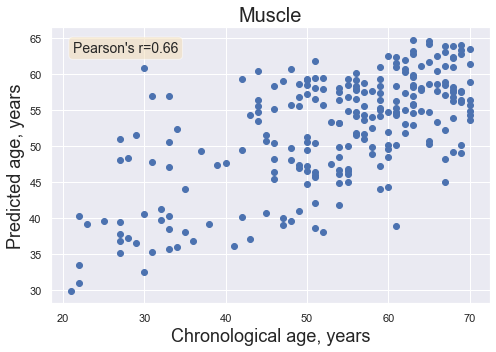

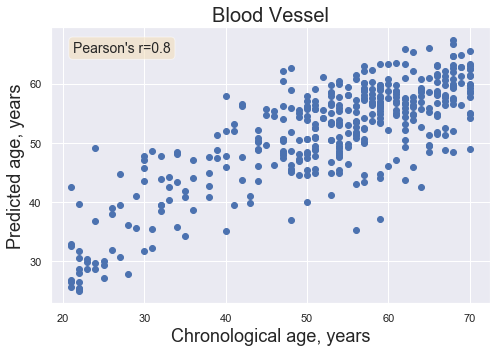

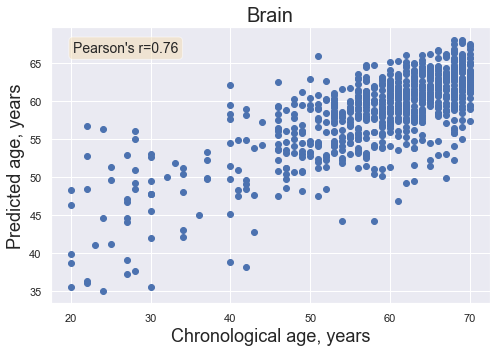

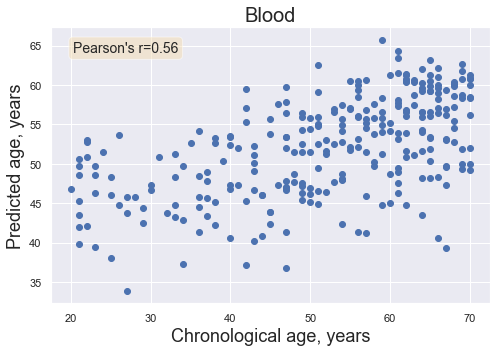

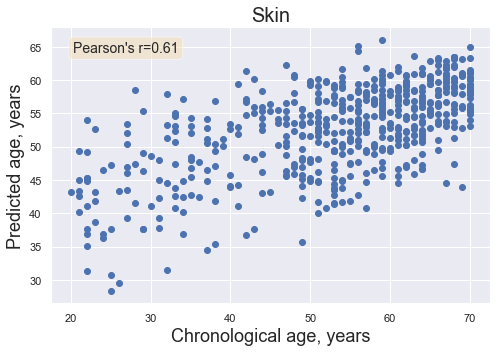

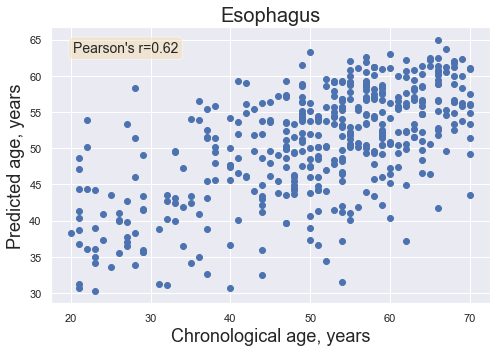

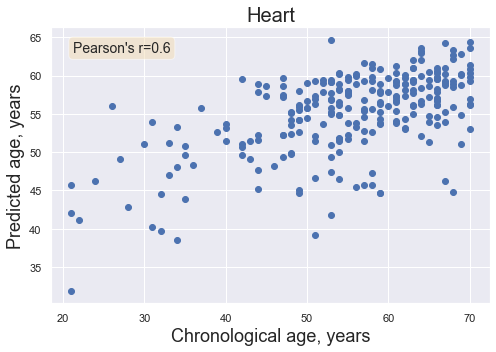

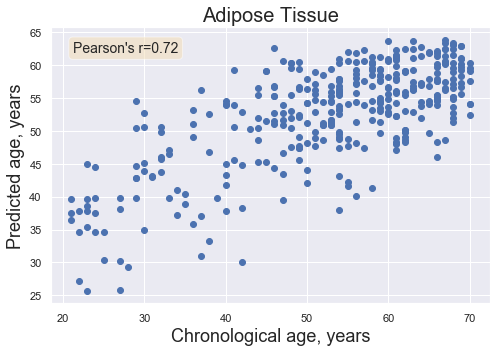

In [30]:
for i, tissue in enumerate(tissues): # all tissues from previous work
    print(tissue)
    print(data[tissue].shape)
    pearson_corr[tissue], true[tissue], prediction[tissue] = \
    fit_xgboost_model(data[tissue], age[tissue])

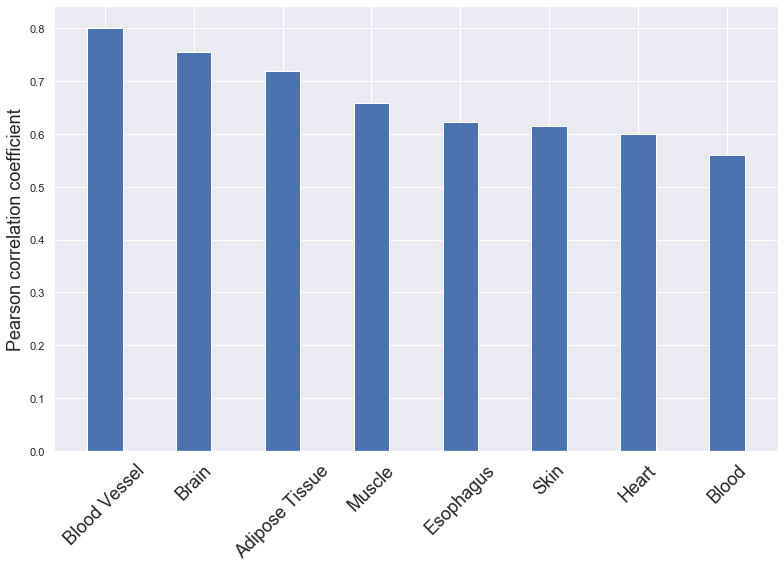

In [31]:
fig, ax = plt.subplots(figsize=(11,8))
n=2
x_coords = np.arange(0,n*len(tissues), n)
ax.set_xticks(np.arange(0,n*len(tissues), n))
coeff = np.asarray([pearson_corr[tissue][0] for tissue in tissues])
ax.set_xticklabels([tissues[i] for i in np.argsort(coeff)[::-1]], rotation=45, fontsize=xlabel_fontsize)
ax.bar(x_coords, coeff[np.argsort(coeff)[::-1]], \
    color='C0', edgecolor='white')
ax.set_ylabel('Pearson correlation coefficient', fontsize=ylabel_fontsize) 
plt.tight_layout()
# pp = "/Users/elvirakinzina/src/Aging_clock/Pictures/Number_of_genes_and_correlation." + figure_format
# plt.savefig(pp, format = figure_format)

In [33]:
subtissues = ['Adipose_Subcutaneous', 'Adipose_Visceral_(Omentum)',
          'Whole_Blood', 'Muscle_Skeletal', 'Skin_Not_Sun_Exposed_(Suprapubic)',
          'Skin_Sun_Exposed_(Lower_leg)', 'Heart_Atrial_Appendage',
          'Heart_Left_Ventricle', 'Esophagus_Gastroesophageal_Junction',
          'Esophagus_Mucosa', 'Esophagus_Muscularis'] # subtissues, skipped blood vessel and brain

In [34]:
for tissue in subtissues:
    data[tissue], age[tissue], SMRIN[tissue], SMTSISCH[tissue] = load_data(tissue, "subtissue")

663  samples,  56200 genes
22349 genes filtered out
0 samples filtered out
541  samples,  56200 genes
22140 genes filtered out
0 samples filtered out
755  samples,  56200 genes
17687 genes filtered out
0 samples filtered out
803  samples,  56200 genes
19544 genes filtered out
0 samples filtered out
604  samples,  56200 genes
22904 genes filtered out
0 samples filtered out
701  samples,  56200 genes
23006 genes filtered out
0 samples filtered out
429  samples,  56200 genes
21462 genes filtered out
0 samples filtered out
432  samples,  56200 genes
19797 genes filtered out
0 samples filtered out
375  samples,  56200 genes
22134 genes filtered out
0 samples filtered out
555  samples,  56200 genes
21896 genes filtered out
0 samples filtered out
515  samples,  56200 genes
21983 genes filtered out
0 samples filtered out


In [66]:
for i, tissue in enumerate(subtissues[:2]):
    print(tissue)
    print(data[tissue].shape)
    cols = list(data[tissue].transpose().columns)
    setcols = set(cols)
    print(len(cols))
    print(len(setcols))
    uniques = [c for c in setcols if cols.count(c) > 1]
    print(uniques)
#     print(data[tissue].transpose().columns)
#     print(age[tissue])

Adipose_Subcutaneous
(22349, 663)
22349
21378
['RP11-504G3', 'RP11-524F11', 'CH507-9B2', 'CTD-2574D22', 'RP11-817O13', 'CH17-472G23', 'RP11-20I23', 'CTD-2035E11', 'RP11-196G11', 'RP11-455O6', 'RP4-657D16', 'RP11-53O19', 'AC000068', 'RP11-114H24', 'AC004540', 'RP11-108M9', 'RP13-270P17', 'RP11-428J1', 'RP11-158M2', 'CTD-3035K23', 'AC096574', 'RP11-1277A3', 'RP11-680G24', 'RP11-753H16', 'CTC-558O2', 'CTC-308K20', 'RP11-13K12', 'RP11-598F7', 'RP11-59H7', 'AC007193', 'CTD-3064M3', 'LINC01238', 'RP11-480I12', 'RP5-1112D6', 'RP11-30K9', 'RP11-493E12', 'RP11-23J9', 'AC137932', 'CTB-31O20', 'RP11-88E10', 'RP11-227G15', 'CTC-471J1', 'CTB-113P19', 'CTD-2036P10', 'CTC-338M12', 'CTC-529I10', 'AC002398', 'RP11-1379J22', 'RP1-59D14', 'RP11-1055B8', 'AC005154', 'RP5-1139B12', 'RP11-6O2', 'RP11-53B2', 'RP5-943J3', 'RP4-816N1', 'RP11-2E11', 'RP5-875H18', 'RP11-94C24', 'XXbac-B444P24', 'RP11-435O5', 'RP11-686D22', 'RP11-855A2', 'CTD-2666L21', 'RP11-214K3', 'AC079922', 'RP11-332H18', 'RP11-894P9', 'RP13-

['RP11-504G3', 'CH507-9B2', 'CTD-2574D22', 'RP11-817O13', 'CH17-472G23', 'RP11-20I23', 'CTD-2035E11', 'RP11-196G11', 'RP11-455O6', 'RP11-53O19', 'AC000068', 'RP11-114H24', 'AC004540', 'RP11-108M9', 'RP13-270P17', 'AC010524', 'RP11-428J1', 'RP11-158M2', 'CTD-3035K23', 'AC096574', 'RP11-1277A3', 'RP11-680G24', 'CTC-558O2', 'CTC-308K20', 'RP11-13K12', 'RP11-598F7', 'AC007193', 'CTD-3064M3', 'RP11-480I12', 'RP5-1112D6', 'RP11-30K9', 'RP11-23J9', 'AC137932', 'CTB-31O20', 'RP11-88E10', 'RP11-227G15', 'CTC-471J1', 'CTB-113P19', 'CTD-2036P10', 'CTC-338M12', 'CTC-529I10', 'AC002398', 'RP11-1379J22', 'RP1-59D14', 'RP11-1055B8', 'AC005154', 'RP5-1139B12', 'RP11-6O2', 'RP11-53B2', 'RP11-2E11', 'XXbac-B444P24', 'RP11-686D22', 'RP11-855A2', 'CTD-2666L21', 'RP11-214K3', 'AC079922', 'RP11-332H18', 'RP13-131K19', 'RP11-295D4', 'RP6-109B7', 'RP11-1334A24', 'RP11-1072A3', 'RP11-358B23', 'CTD-2527I21', 'RP11-378J18', 'AF127936', 'RP11-216N14', 'RP11-2C24', 'CTC-559E9', 'RP3-331H24', 'RP11-863K10', 'CTD-25

In [67]:
for i, tissue in enumerate(subtissues[:1]):
    transposed = data[tissue].transpose()
    print(transposed['RP11-504G3'])

                          RP11-504G3  RP11-504G3
GTEX-1117F-0226-SM-5GZZ7          12           9
GTEX-111CU-1826-SM-5GZYN           0           5
GTEX-111FC-0226-SM-5N9B8          11          19
GTEX-111VG-2326-SM-5N9BK          21          11
GTEX-111YS-2426-SM-5GZZQ           4           6
...                              ...         ...
GTEX-ZYVF-0226-SM-5GIEG           10           8
GTEX-ZYW4-0226-SM-5E44M            8           2
GTEX-ZYY3-0226-SM-5E45M            7           4
GTEX-ZZ64-1626-SM-5E43W            5           6
GTEX-ZZPU-2726-SM-5NQ8O           10           2

[663 rows x 2 columns]


In [52]:
for i, tissue in enumerate(subtissues): # all tissues from previous work
    print(tissue)
    print(data[tissue].shape)
    pearson_corr[tissue], true[tissue], prediction[tissue] = \
    fit_xgboost_model(data[tissue], age[tissue])

Adipose_Subcutaneous
(22349, 663)
data done
(464, 22349) (199, 22349) (464,) (199,)
Index(['WASH7P', 'RP11-34P13', 'RP11-34P13', 'RP11-34P13', 'RP11-34P13',
       'AP006222', 'RP4-669L17', 'RP5-857K21', 'MTND1P23', 'MTND2P28',
       ...
       'MT-ATP8', 'MT-ATP6', 'MT-CO3', 'MT-ND3', 'MT-ND4L', 'MT-ND4', 'MT-ND5',
       'MT-ND6', 'MT-TE', 'MT-CYB'],
      dtype='object', length=22349)


AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [ ]:
fig, ax = plt.subplots(figsize=(11,8))
n=2
x_coords = np.arange(0,n*len(subtissues), n)
ax.set_xticks(np.arange(0,n*len(subtissues), n))
coeff = np.asarray([pearson_corr[tissue][0] for tissue in subtissues])
ax.set_xticklabels([subtissues[i] for i in np.argsort(coeff)[::-1]], rotation=45, fontsize=xlabel_fontsize)
ax.bar(x_coords, coeff[np.argsort(coeff)[::-1]], \
    color='C0', edgecolor='white')
ax.set_ylabel('Pearson correlation coefficient', fontsize=ylabel_fontsize) 
plt.tight_layout()
# pp = "/Users/elvirakinzina/src/Aging_clock/Pictures/Number_of_genes_and_correlation." + figure_format
# plt.savefig(pp, format = figure_format)

Muscle
(19544, 803)
data done
(562, 19544) (241, 19544) (562,)
done prior to search
done after search
   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0     473.967647     10.445853         0.833926        0.020416   
1     622.312801     10.096117         0.922099        0.025941   
2     500.183423     17.639331         0.855999        0.064464   
3     360.104715      3.345290         0.962760        0.084082   
4     838.923478      9.596142         0.820042        0.032368   
5     511.066628     15.341116         0.924046        0.143510   
6     404.775849     29.738498         0.877391        0.198714   
7     358.057903      9.548917         0.907325        0.199782   
8     419.144395     23.219744         0.708222        0.143399   
9     255.758977     18.452285         0.477327        0.112378   

  param_subsample param_n_estimators param_min_child_weight param_max_depth  \
0               1                150                      2              10   
1 

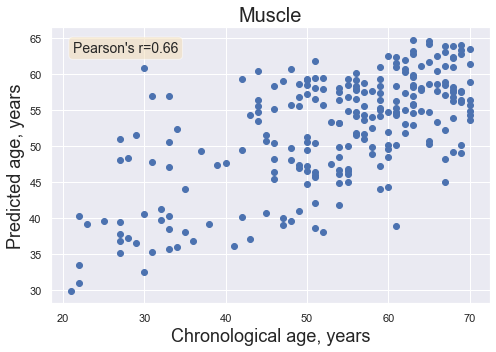

In [14]:
for i, tissue in enumerate(tissues[:1]): # only muscle
    print(tissue)
    print(data[tissue].shape)
    pearson_corr[tissue], true[tissue], prediction[tissue] = \
    fit_xgboost_model(data[tissue], age[tissue], n_iter=10)
#     fit_xgboost_model(residual_no_outliers[tissue], ages[tissue], n_iter=3)    

In [ ]:
# from above: looks like hyperparams are good {'subsample': 1.0, 'n_estimators': 150, 'min_child_weight': 1, 'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 0.9}
-9.294894931041103

Blood Vessel
data done
(931, 21218) (400, 21218) (931,)
done prior to search
done after search
   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0    1098.114059      6.349692         1.309571        0.096354   
1    1327.970546    114.944392         1.108240        0.259854   
2    1003.519009     43.056386         0.900258        0.094595   

  param_subsample param_n_estimators param_min_child_weight param_max_depth  \
0               1                150                      2              10   
1             0.9                200                      8              10   
2               1                100                      4              12   

  param_learning_rate param_colsample_bytree  ... mean_test_score  \
0                0.01                    0.8  ...      -15.292804   
1                0.01                      1  ...      -11.465545   
2                 0.3                      1  ...       -8.995537   

   std_test_score  rank_test_score  split0

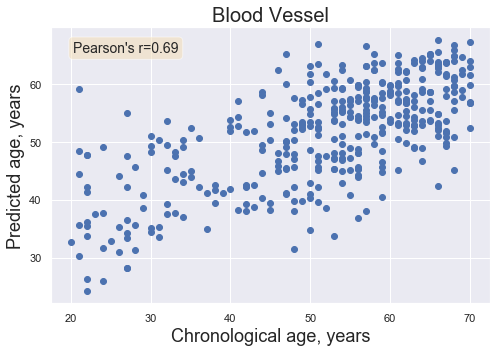

In [26]:
for i, tissue in enumerate(tissues[1:]): # only blood vessel
    print(tissue)
    pearson_corr[tissue], true[tissue], prediction[tissue] = \
    fit_xgboost_model(residual_no_outliers[tissue], ages[tissue], n_iter=3)

# Additional analysis

### Comparing prediction accuracy for different tissues

In [ ]:
fig, ax = plt.subplots(figsize=(11,8))
n=2
x_coords = np.arange(0,n*len(tissues), n)
ax.set_xticks(np.arange(0,n*len(tissues), n))
coeff = np.asarray([pearson_corr[tissue][0] for tissue in tissues])
ax.set_xticklabels([tissues[i] for i in np.argsort(coeff)[::-1]], rotation=45, fontsize=xlabel_fontsize)
ax.bar(x_coords, coeff[np.argsort(coeff)[::-1]], \
    color='C0', edgecolor='white')
ax.set_ylabel('Pearson correlation coefficient', fontsize=ylabel_fontsize) 
plt.tight_layout()
pp = "/Users/elvirakinzina/src/Aging_clock/Pictures/Number_of_genes_and_correlation." + figure_format
# plt.savefig(pp, format = figure_format)


## Define most important covariates
These could be included in the model or regressed out to improve age prediction

In [ ]:
def gaussian_project(data, standardize=True, noise=1e-6):
    """ Project each row onto gaussian with matched mean, stdev 

    standardize : bool
        project each row onto N(0, 1), otherwise use N(mu_row, sigma_row),
        where mu_row is the mean of the row and sigma_row is the standard
        deviation
    noise : float
        add random noise drawn from interval (0, noise) to break ties
    """
    # add random noise to break ties
    err = np.random.random(data.shape) * noise
    data = data + err

    ppt = data.rank(axis=1) / (float(data.shape[1])+1.)
    if standardize:
        df = pd.DataFrame(ss.norm.ppf(ppt), index=ppt.index, 
                          columns=ppt.columns)
    else:
        mu = data.mean(axis=1)
        sigma = data.std(axis=1)
        df = {}
        for r in ppt.index:
            df[r] = pd.Series(ss.norm.ppf(ppt.loc[r], loc=mu.loc[r],
                                          scale=sigma.loc[r]), index=ppt.columns)
        df = pd.DataFrame(df).T
    return df
def find_covars_corr_with_first_2_pcs(tissue, data, ax):
        dt = data.copy()
        dt_g = gaussian_project(dt)

        pca = PCA().fit(dt_g)

        # extract principal components
        comps = pd.DataFrame(pca.components_.T, index=dt_g.columns,
                             columns=['PC%i' % (i+1) for i in range(len(pca.components_))])
        
        # choose potential important covariates (add whatever you are interesred in)
        covars = ['SMRIN', 'SMTSISCH', 'TRISCHD', 'ETHNCTY', 'RACE', 'AGE', 'BMI', 'SMNTRNRT', 'DTHRFG', 'DTHVNT', \
                  'SMATSSCR', 'SMALTALG', 'DTHHRDY', 'DTHHRDY']
        print('components', pca.explained_variance_ratio_[0:10])
    
        if np.fabs(sum(pca.explained_variance_ratio_)-1)>0.1:
            print('sum', sum(pca.explained_variance_ratio_))
        
        covs_r = {}
        covs_p = {}
        for pc in ['PC{}'.format(i+1) for i in range(10)]:
            _r = {}
            _p = {}
            for cv in covars:
                if cv in sampleMetaData.columns:
                    covar_vals = np.asarray(sampleMetaData.loc[comps.index, cv])
                elif cv in subjectMetaData.columns:
                    sample_subject_ids = [index.split("-")[0] + "-" + index.split("-")[1] \
                                 for index in list(comps.index)]
                    covar_vals = np.asarray(subjectMetaData.loc[sample_subject_ids, cv])
                _r[cv], _p[cv] = ss.pearsonr(covar_vals[np.isfinite(covar_vals)], \
                                             comps.loc[np.isfinite(covar_vals), pc])
                covs_r[pc] = pd.Series(_r)
                covs_p[pc] = pd.Series(_p)
        covs_r = pd.DataFrame(covs_r).loc[:, ['PC{}'.format(i+1) for i in range(10)]]
        covs_p = pd.DataFrame(covs_p).loc[:, ['PC{}'.format(i+1) for i in range(10)]]

        covarsMain = [covar for covar in covars if (covs_p.loc[covar,:][0:10]<0.05).any()==True]
        first_2_pcs_pars = [covar for covar in covars if (covs_p.loc[covar,:][0:2]<0.05).any()==True]
        ax.set_title(tissue)
        sns.heatmap(-1*np.log10(covs_p.loc[covarsMain,:]), ax=ax, vmax=10, annot=True, fmt=".1f")
        return(first_2_pcs_pars)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
first_2_pcs_pars = find_covars_corr_with_first_2_pcs('Muscle', data['Muscle'], ax)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
first_2_pcs_pars = find_covars_corr_with_first_2_pcs('Esophagus', data['Esophagus'], ax)

## Color PCA by parameter (age, RNA quality, ischemic time before) values to explore important parameters for each tissue

You can look at other technical or phenotypic covariates to find those that can possibly explain PCA patterns for tissues that clearly have clusters: skin and esophagus

In [ ]:
def plot_pca_colored_by(data, parameter):
    fig, ax = plt.subplots(1, 1, figsize=(7, 5))
    pca = decomposition.PCA(n_components=2)
    X = data.transpose().copy()
    pca.fit(X)
    y = np.asarray(parameter)
    X = pca.transform(X)
    y_no_na = y[np.where(np.isfinite(y))]
    y_min = np.min(y_no_na)
    y_max = np.max(y_no_na)
    
    for i in range(len(X[:, 0])):
        if np.isfinite(y[i]):
            alpha = float((y[i]-y_min)/float(y_max-y_min))
            ax.scatter(X[i, 0], X[i, 1], color = 'green', alpha = alpha, s=15)

In [ ]:
plot_pca_colored_by(residual_no_outliers["Esophagus"], SMTSISCH["Esophagus"])

## Sample size of each tissue
I chose top 8 tissues for the analysis above

In [ ]:
# tissues = list(set(sampleMetaData['SMTS']))
# sample_num = dict()
# for tissue in tissues:
#         data[tissue], age[tissue], SMRIN[tissue], SMTSISCH[tissue] = load_data(tissue)
#         sample_num[tissue] = data[tissue].shape[1]
# out_file = "/om2/user/elvira/src/data/GTEx_v8/rna_seq/Tissues_sample_numbers.pkl"
# with open(out_file, "wb") as f:
#     pickle.dump(sample_num,f,pickle.HIGHEST_PROTOCOL)

In [ ]:
sample_num = pd.read_pickle("/om2/user/elvira/src/data/GTEx_v8/rna_seq/Tissues_sample_numbers.pkl")
tissues = list(sample_num.keys())
sample_numbers = np.asarray([sample_num[tissue] for tissue in tissues])
indices = np.argsort(sample_numbers)[::-1]
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
ax.bar(range(len(tissues)), sample_numbers[indices])
ax.set_xticks(range(len(tissues)))
ax.set_xticklabels([tissues[index] for index in indices], rotation = 90)

## Plot sample age distribution for each tissue
Most samples are from elderly since they die more often

In [ ]:
for tissue in tissues:
    fig, ax = plt.subplots(1, 1, figsize=(4, 3))
    ax.hist(age[tissue])
    ax.set_title(tissue, fontsize=title_fontsize)